In [14]:
from pathlib import Path
import glob

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed
from IPython.display import display
import numpy as np

import torch
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.transforms import (
    LoadImage,
    LoadImaged
)

print_config()

MONAI version: 0.4.0
Numpy version: 1.19.4
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0563a4467fa602feca92d91c7f47261868d171a1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.0
Pillow version: 8.0.1
Tensorboard version: 2.4.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.8.2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.54.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
data_dir = Path().absolute().parents[1] / "data/lung-tumor-segmentation/Task06_Lung"
if not data_dir.exists():
    data_dir.mkdir()

In [3]:
train_images = sorted(glob.glob(str(data_dir/"imagesTr"/"*.nii.gz")))
train_labels = sorted(glob.glob(str(data_dir/"labelsTr"/"*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)
]
train_data_dicts = data_dicts

In [4]:
train_data_dicts[0]

{'image': '/Users/felix/code/ml/ml-experiments/data/lung-tumor-segmentation/Task06_Lung/imagesTr/lung_001.nii.gz',
 'label': '/Users/felix/code/ml/ml-experiments/data/lung-tumor-segmentation/Task06_Lung/labelsTr/lung_001.nii.gz'}

In [5]:
loader = LoadImage(dtype=np.float32)

In [6]:
img, meta = loader(train_data_dicts[0]["image"])

In [7]:
print(f"input: {train_data_dicts[0]['image']}")
print(f"image shape: {img.shape}")
print(f"image affine:\n{meta['affine']}")
print(f"image pixdim:\n{meta['pixdim']}")

input: /Users/felix/code/ml/ml-experiments/data/lung-tumor-segmentation/Task06_Lung/imagesTr/lung_001.nii.gz
image shape: (512, 512, 304)
image affine:
[[  -0.69335938    0.            0.          182.15332031]
 [   0.            0.69335938    0.          -40.15332031]
 [   0.            0.            1.         -305.        ]
 [   0.            0.            0.            1.        ]]
image pixdim:
[-1.         0.6933594  0.6933594  1.         0.         0.
  0.         0.       ]


In [5]:
loader = LoadImaged(keys=("image", "label"))

In [6]:
data_dict = loader(train_data_dicts[0])
print(f"input:, {train_data_dicts[0]}")
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image pixdim:\n{data_dict['image_meta_dict']['pixdim']}")

input:, {'image': '/Users/felix/code/ml/ml-experiments/data/lung-tumor-segmentation/Task06_Lung/imagesTr/lung_001.nii.gz', 'label': '/Users/felix/code/ml/ml-experiments/data/lung-tumor-segmentation/Task06_Lung/labelsTr/lung_001.nii.gz'}
image shape: (512, 512, 304)
label shape: (512, 512, 304)
image pixdim:
[-1.         0.6933594  0.6933594  1.         0.         0.
  0.         0.       ]


In [28]:
def plot_seg_image(image, label, d_level):
    plt.figure("visualize", (6, 6))
    #plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image[:, :, d_level], cmap="gray")
    #plt.subplot(1, 2, 2)
    #plt.title("label")
    plt.imshow(label[:, :, d_level], alpha=0.3)
    plt.show()

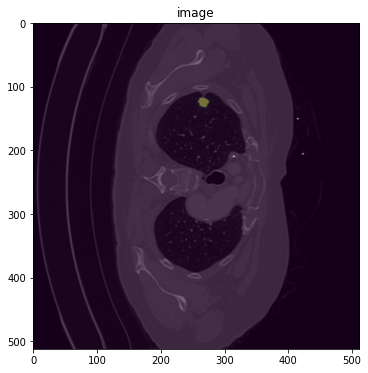

In [29]:
image, label = data_dict["image"], data_dict["label"]
plot_seg_image(image, label, 240)

In [30]:
depth = image.shape[2]
interact(plot_seg_image, d_level=widgets.IntSlider(value=int(depth/2), max=(depth-1)), image=fixed(image), label=fixed(label))

interactive(children=(IntSlider(value=152, description='d_level', max=303), Output()), _dom_classes=('widget-i…

<function __main__.plot_seg_image(image, label, d_level)>